## Introduction

In this Jupyter Notebook we will experimentally verify the results of the Gambler's Ruin problem, in the general case (where the coin may be biased).

## Installation of Dependencies

First, we begin by installing the necessary dependencies for this notebook.

In [1]:
import numpy as np
import ipywidgets as widgets
import plotly.graph_objects as go

## Experiment

In the following widgets, we can choose the number of experiments, then watch an animated line chart as the experiments run.

In [2]:
# Create a text input widget
style = {'description_width': 'initial'}
user_input1 = widgets.Text(
    value='',
    placeholder='30',
    description='Number of Experiments:',
    style=style,
    disabled=False
)

# Display the widget
display(user_input1)

Text(value='', description='Number of Experiments:', placeholder='30', style=DescriptionStyle(description_widt…

In [3]:
# Create a text input widget
style = {'description_width': 'initial'}
user_input2 = widgets.Textarea(
    value='',
    placeholder='...',
    description='Initial wealth_Goal wealth:',
    style=style,
    disabled=False
)

# Display the widget
display(user_input2)

Textarea(value='', description='Initial wealth_Goal wealth:', placeholder='...', style=DescriptionStyle(descri…

In [4]:
# Create a sliding floating point widget
user_input3 = widgets.FloatSlider(
    value=0.5,
    min=0.0,
    max=1.0,
    step=0.05,
    description='Probability of Heads:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
    style = style
)

# Display the widget
display(user_input3)

FloatSlider(value=0.5, continuous_update=False, description='Probability of Heads:', max=1.0, step=0.05, style…

In [5]:
# Setting up a random number generator with a fixed state for reproducibility.
rng = np.random.default_rng(seed=316)

In [6]:
# Build wealth paths
num_experiments = int(user_input1.value) if user_input1.value.isdigit() else 30

initial_wealth, goal_wealth = (int(num) for num in user_input2.value.split())

prob_heads = user_input3.value
prob_tails = 1 - prob_heads

win_lose = np.array([1, -1])
probs = np.array([prob_heads, prob_tails])

def outcome(win_lose: np.array, probs: np.array) -> int:
    outcome = rng.choice(a=win_lose, p=probs)
    return outcome

In [7]:
# Optimized simulation using vectorized chunking
all_paths = []
max_steps = 0

# Scale chunk size to the problem 
# expected duration is O(initial_wealth * (goal_wealth - initial_wealth))
chunk_size = max(1000, initial_wealth * (goal_wealth - initial_wealth))

for _ in range(num_experiments):
    wealth = initial_wealth
    segments = [np.array([wealth])]
    
    while 0 < wealth < goal_wealth:
        steps = rng.choice(win_lose, size=chunk_size, p=probs)
        wealth_trajectory = wealth + np.cumsum(steps)
        
        boundary_hits = np.where((wealth_trajectory <= 0) | (wealth_trajectory >= goal_wealth))[0]
        
        if boundary_hits.size > 0:
            stop_idx = boundary_hits[0]
            segment = wealth_trajectory[:stop_idx + 1]
            # Clamp final value to exact boundary
            segment[-1] = np.clip(segment[-1], 0, goal_wealth)
            segments.append(segment)
            break
        else:
            segments.append(wealth_trajectory)
            wealth = wealth_trajectory[-1]
    
    path = np.concatenate(segments)
    all_paths.append(path)
    max_steps = max(max_steps, len(path))

# Pad all paths to max_steps with NaN (NaN is not rendered by Plotly/Scattergl)
# This avoids per-frame slicing entirely
padded_paths = np.full((num_experiments, max_steps), np.nan)
for i, path in enumerate(all_paths):
    padded_paths[i, :len(path)] = path

# Single x-axis array, reused by all traces and frames
x_vals = list(range(max_steps))

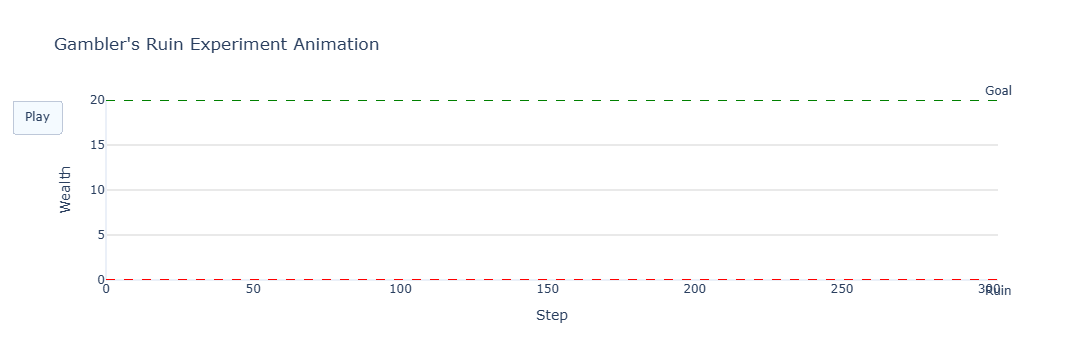

In [11]:
# Use Scattergl for WebGL-accelerated rendering
fig = go.Figure(
    layout=go.Layout(
        template="plotly_white",
        xaxis=dict(range=[0, max_steps], title="Step", showgrid=False),
        yaxis=dict(range=[0, goal_wealth], title="Wealth", gridcolor='lightgrey'),
        title="Gambler's Ruin Experiment Animation",
        hovermode=False,  # Disable hover — significant rendering speedup
        updatemenus=[{
            "type": "buttons",
            "buttons": [{"label": "Play", "method": "animate", 
                         "args": [None, 
                                  {"frame": {"duration": 100, 
                                             "redraw": True}, 
                                             "fromcurrent": True}]}]
        }]
    )
)

# Add initial traces using Scattergl
for i in range(num_experiments):
    fig.add_trace(go.Scattergl(
        x=[0], 
        y=[initial_wealth], 
        name=f"Exp {i+1}", 
        mode="lines",
        line=dict(width=1, color='blue'),
        opacity=0.2,
        showlegend=False
    ))

# Add reference lines BEFORE traces so they don't interfere with frame trace indexing
# Actually, move hlines to shapes instead — they don't add phantom traces
fig.add_shape(type="line", x0=0, x1=max_steps, y0=goal_wealth, y1=goal_wealth,
              line=dict(dash="dash", color="green"))
fig.add_shape(type="line", x0=0, x1=max_steps, y0=0, y1=0,
              line=dict(dash="dash", color="red"))
fig.add_annotation(x=max_steps, y=goal_wealth, text="Goal", showarrow=False, yshift=10)
fig.add_annotation(x=max_steps, y=0, text="Ruin", showarrow=False, yshift=-10)

# Ensure we have a reasonable number of frames (e.g., max 50)
target_num_frames = 50
step_size = max(1, max_steps // target_num_frames)

# Convert padded paths to Python lists once (rows of the 2D array)
rows = [padded_paths[i].tolist() for i in range(num_experiments)]

# Build frames — include full trace style to prevent style reset
frames = []
for k in range(1, max_steps + 1, step_size):
    frame_data = []
    for i in range(num_experiments):
        frame_data.append(go.Scattergl(
            x=x_vals[:k],
            y=rows[i][:k],
            mode="lines",
            line=dict(width=1, color='blue'),
            opacity=0.2,
            showlegend=False
        ))
    frames.append(go.Frame(data=frame_data, name=str(k)))

# Final frame shows everything
final_data = [go.Scattergl(
    x=x_vals, 
    y=rows[i], 
    mode="lines",
    line=dict(width=1, color='blue'),
    opacity=0.2,
    showlegend=False
) for i in range(num_experiments)]
frames.append(go.Frame(data=final_data, name=str(max_steps)))

fig.frames = frames
fig.show()

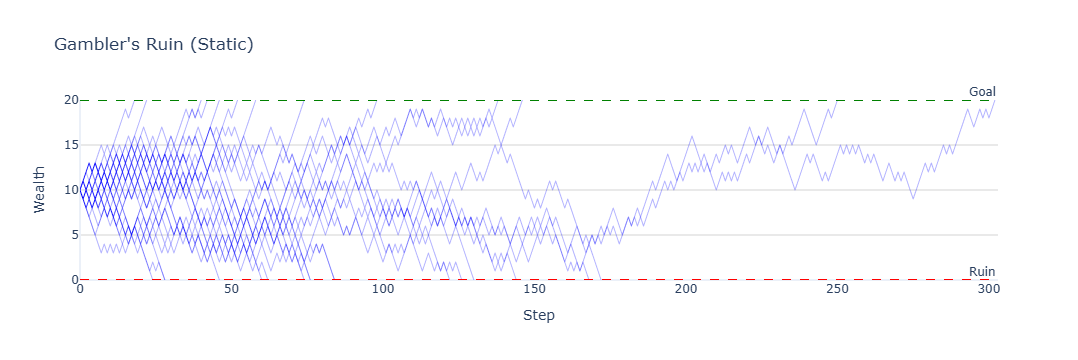

In [9]:
# Static plot for large simulations — no animation overhead
fig_static = go.Figure(
    layout=go.Layout(
        template="plotly_white",
        xaxis=dict(range=[0, max_steps], title="Step", showgrid=False),
        yaxis=dict(range=[0, goal_wealth], title="Wealth", gridcolor='lightgrey'),
        title="Gambler's Ruin (Static)",
        hovermode=False
    )
)

for i, path in enumerate(all_paths):
    fig_static.add_trace(go.Scattergl(
        x=list(range(len(path))),
        y=path.tolist(),
        mode="lines",
        line=dict(width=1, color='blue'),
        opacity=0.3,
        showlegend=False
    ))

fig_static.add_hline(y=goal_wealth, line_dash="dash", line_color="green", annotation_text="Goal")
fig_static.add_hline(y=0, line_dash="dash", line_color="red", annotation_text="Ruin")
fig_static.show()